In [1]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import seaborn as sns

import nltk
import re

from tqdm import trange
from nltk import tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter

import plotly.express as px

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df_data = pd.read_parquet('/content/gdrive/MyDrive/NLP_project_MOVS/data.gzip')

In [77]:
df_data.shape

(49312, 8)

# Описательный анализ наблюдений

In [11]:
tokenizer = RegexpTokenizer(r'\w+')

data_exploded = df_data.explode('caption')
sentences = data_exploded['caption'].tolist()

sentences_tokenized = [tokenizer.tokenize(sentence) for sentence in sentences]

words = []
for sentence in sentences_tokenized:
  for word in sentence:
    words.append(word)
print('Число предложений', len(sentences))

Число предложений 246700


In [13]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
words_without_stops = [word for word in words if not word.lower() in stop_words]
print('Число слов без стоп-слов', len(words_without_stops))
print('Доля слов без стоп-слов', len(words_without_stops) / len(words))

Число слов без стоп-слов 1422817
Доля слов без стоп-слов 0.551509384230152


In [14]:
# Статистика по длине предложения
lengths_sentences = [len(sentence) for sentence in sentences_tokenized]

min_length_sentences = min(lengths_sentences)
max_length_sentences = max(lengths_sentences)
avg_length_sentences = sum(lengths_sentences) / len(lengths_sentences)

print("Minimum sentence length:", min_length_sentences)
print("Maximum sentence length:", max_length_sentences)
print("Average sentence length:", avg_length_sentences)

Minimum sentence length: 6
Maximum sentence length: 49
Average sentence length: 10.457478719092014


In [15]:
sentences_without_stopwords = [
    [word for word in sentence if word.lower() not in stop_words]
    for sentence in sentences_tokenized
]

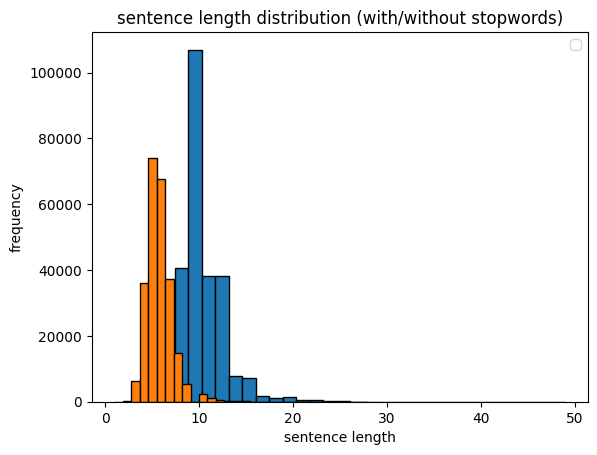

In [22]:
plt.hist(lengths_sentences, bins=30, edgecolor='black')
plt.hist([len(sentence) for sentence in sentences_without_stopwords], bins=30, edgecolor='black')
plt.xlabel('sentence length')
plt.ylabel('frequency')
plt.title('sentence length distribution (with/without stopwords)')
plt.legend()
plt.show()

In [23]:
# Статистика по длине слова

lengths_words = [len(word) for word in words]

min_length_words = min(lengths_words)
max_length_words = max(lengths_words)
avg_length_words = sum(lengths_words) / len(lengths_words)

print("Minimum word length:", min_length_words)
print("Maximum word length:", max_length_words)
print("Average word length:", avg_length_words)

Minimum word length: 1
Maximum word length: 17
Average word length: 4.0151302783872


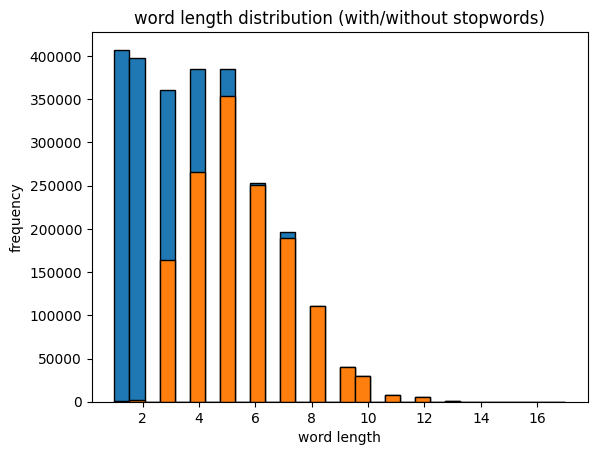

In [24]:
plt.hist(lengths_words, bins=30, edgecolor='black')
plt.hist([len(word) for word in words_without_stops], bins=30, edgecolor='black')
plt.xlabel('word length')
plt.ylabel('frequency')
plt.title('word length distribution (with/without stopwords)')
plt.show()

In [ ]:
# Cтатистика по частям речи

import spacy

nlp = spacy.load("en_core_web_sm")

pos_all = []

for sentence in sentences:
  pos_sentence = []
  doc = nlp(sentence)
  for token in doc:
      pos_sentence.append(token.pos_)
  pos_all.append(pos_sentence)

pos_counts = {}
for pos_sentence in pos_all:
    for pos_tag in pos_sentence:
        if pos_tag in pos_counts:
            pos_counts[pos_tag] += 1
        else:
            pos_counts[pos_tag] = 1

for pos_tag, count in pos_counts.items():
    plt.bar(pos_tag, count)

plt.xlabel('pos tags')
plt.ylabel('frequency')
plt.title('distribution of pos tags')
plt.xticks(rotation=90)
plt.show()

In [ ]:
from collections import Counter

avg_counts = {pos: count / len(sentences) for pos, count in sorted(pos_counts.items(), key=lambda item: item[1], reverse=True)}

output = ",\n".join([f"{avg_count:.2f} {pos}" for pos, avg_count in avg_counts.items()])
print(f"In average, there are {output} tags in a sentence.")

# Топ слов, tf-idf

In [ ]:
# !pip install pymorphy2

from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
import re
import nltk

m = MorphAnalyzer()
regex = re.compile("[a-zA-Z0-9-]+")

sw = stopwords.words('english')

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

def remove_stopwords(lemmas, stopwords = sw):
    return [w for w in lemmas if not w in stopwords]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)

    return ' '.join(remove_stopwords(lemmas))

In [42]:
df = df_data.reset_index(drop=True)
df['captions_lemmatized'] = df['caption'].apply(lambda x: clean_text(' '.join(x)))

In [51]:
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df['captions_lemmatized'][i].split(' ')
len(corpus)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 49312/49312 [00:00<00:00, 57964.86it/s]


1421127

In [54]:
mostCommon = Counter(corpus).most_common(10)
mostCommon[:10]

words = []
freq = []
for word, count in mostCommon[:10]:
    words.append(word)
    freq.append(count)

fig = px.bar(x=freq, y=words, orientation='h')
fig.show()

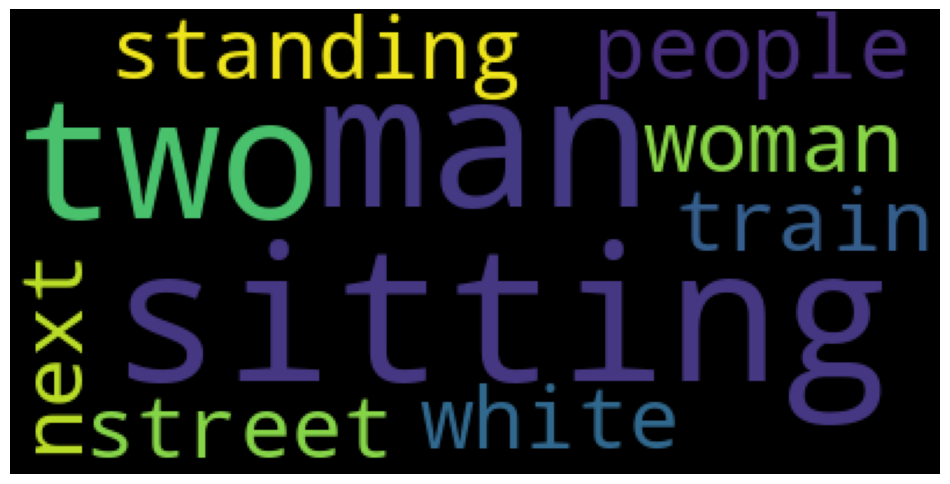

In [55]:
from wordcloud import WordCloud
plt.figure(figsize=(12,8))
word_cloud = WordCloud(background_color='black',
                       max_font_size = 80
                      ).generate(" ".join([x[0] for x in mostCommon[:50]]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def get_tfidf(documents, n_top=10, sort_type='top'):
  tfidf_vectorizer = TfidfVectorizer(stop_words='english')
  tfidf = tfidf_vectorizer.fit_transform(documents)
  importance = np.argsort(np.asarray(tfidf.sum(axis=0)).ravel())[::-1]
  tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

  if sort_type == 'top':
    return tfidf_feature_names[importance[:n_top]]
  elif sort_type == 'tail':
    return tfidf_feature_names[importance[-n_top:-1]]

  else: pass

In [69]:
print('Top words:', get_tfidf(df['captions_lemmatized'], sort_type='top'))
print('Anti top words:', get_tfidf(df['captions_lemmatized']))

Top words: ['man' 'people' 'sitting' 'standing' 'street' 'train' 'woman' 'white'
 'table' 'tennis']
Anti top words: ['man' 'people' 'sitting' 'standing' 'street' 'train' 'woman' 'white'
 'table' 'tennis']


#### Атрибуты

In [88]:
def get_attrs(js):
    attributes = list()
    for d in js:
        try:
            attributes.append(d['attributes'])
        except:
            pass
    return attributes

def flatten(l):
    return [item for sublist in l for item in sublist]

In [105]:
# a = df['attributes'].apply(get_attrs)
# a = a.apply(flatten)
# type(flatten(a)[2])
# [flatten(x) if isinstance(x, np.ndarray) else None for x in flatten(a)]

In [74]:
# words = []
# freq = []
# for word, count in mostCommon[:10]:
#     words.append(word)
#     freq.append(count)

In [106]:
# import plotly.express as px
# fig = px.bar(x=freq, y=words, orientation='h')
# fig.show()

In [107]:
# from wordcloud import WordCloud
# plt.figure(figsize=(12,8))
# word_cloud = WordCloud(
#                           background_color='black',
#                           max_font_size = 80
#                          ).generate(" ".join([x[0] for x in mostCommon[:50]]))
# plt.imshow(word_cloud)
# plt.axis('off')
# plt.show()

### Объекты

In [109]:
def get_obj(js):
    objects = list()
    for d in js:
        # try:
            objects.append(d['names'])
        # except:
        #     pass
    return objects

In [110]:
o = df['objects'].apply(get_obj)
o = o.apply(flatten)

corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += o[i]
print(len(corpus))

mostCommon = Counter(corpus).most_common(100)
mostCommon[:10]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 49312/49312 [00:00<00:00, 103265.49it/s]


1772425


[('man', 44433),
 ('person', 32379),
 ('window', 26321),
 ('tree', 21710),
 ('shirt', 21455),
 ('wall', 19774),
 ('woman', 19150),
 ('sky', 18435),
 ('ground', 18381),
 ('building', 18127)]

In [112]:
words = []
freq = []
for word, count in mostCommon[:10]:
    words.append(word)
    freq.append(count)

In [114]:
fig = px.bar(x=freq, y=words, orientation='h')
fig.show()

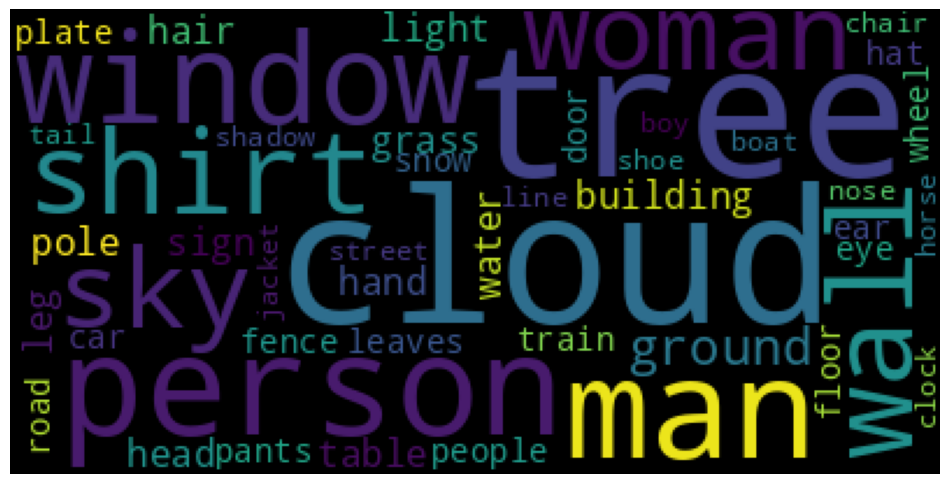

In [115]:
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join([x[0] for x in mostCommon[:50]]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### Регионы

In [116]:
def get_reg(js):
    regions = list()
    for d in js:
        # try:
            regions.append(d['phrase'])
        # except:
        #     pass
    return ' '.join(regions)

In [119]:
reg = df['regions'].apply(get_reg)
reg = reg.apply(lambda x: clean_text(x))

def corpus(text):
    text_list = text.split()
    return text_list

reg = reg.apply(corpus)

corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += reg[i]

print(len(corpus))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 49312/49312 [00:00<00:00, 92549.91it/s]

7868227


In [120]:
mostCommon = Counter(corpus).most_common(100)

words = []
freq = []
for word, count in mostCommon[:10]:
    words.append(word)
    freq.append(count)

In [121]:
import plotly.express as px
fig = px.bar(x=freq, y=words, orientation='h')
fig.show()

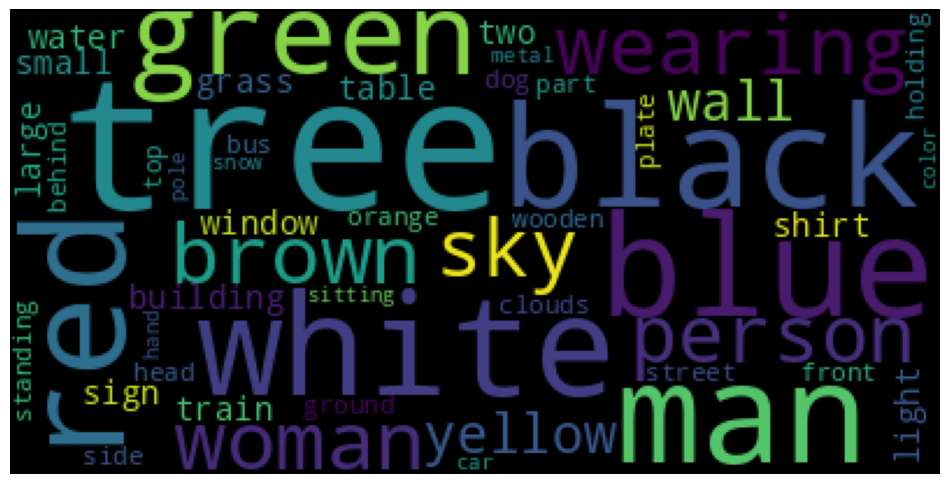

In [122]:
from wordcloud import WordCloud
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join([x[0] for x in mostCommon[:50]]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

# Анализ коллокаций/n-граммов

удалю стоп слова

In [123]:
not_stopwords = {'not', 'no'}
final_stop_words = set([word for word in stopwords.words('english') if word not in not_stopwords])

In [127]:
def clean(review):
    review = ' '.join(review).lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review)
    review = " ".join([word for word in review.split() if word not in final_stop_words])

    return review

df = df_data.copy()['caption']
df = pd.Series(df).apply(clean)
df.head(10)

0     tourists find blue signs like great britain ro...
1     large dog sitting next wooden table brown near...
2     twp females walking tennis court carrying tenn...
3     pair zebra standing large open area two zebras...
4     white blue bus driving past houses city street...
5     beach two surfers holding boards single board ...
6     pigeon sitting top white table bird standing m...
8     red parrot eating food palm hand persons arm p...
9     woman long hair crowd looking mobile phone lon...
10    woman watches plane boardwalk woman stands oce...
Name: caption, dtype: object

### Биграммы

In [128]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df)
count_values = bigrams.toarray().sum(axis=0)
n2gram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
n2gram_freq.columns = ["frequency", "ngram"]

In [129]:
top_n = 100
fig = px.bar(x=n2gram_freq['frequency'][:top_n], y=n2gram_freq['ngram'][:top_n])
fig.show()

## Три граммы

In [23]:
cv = CountVectorizer(ngram_range=(3,3))
trigrams = cv.fit_transform(df)
count_values = trigrams.toarray().sum(axis=0)
n3gram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
n3gram_freq.columns = ["frequency", "ngram"]

In [24]:
top_n = 100
fig = px.bar(x=n3gram_freq['frequency'][:top_n], y=n3gram_freq['ngram'][:top_n])
fig.show()

Очевидно, названия улиц, автобусов, длин предметов, количества предметов встречаются реже всего (1 раз), необходимо понять надо ли это убирать из предложений

Итак, самые часто встречающиеся ngrams можно поделить на несколько групп:

1. Состояние людей/предметов: sitting next, standing next, riding, playing, holding, hitting, flying
2. Описание людей/предметов: young man
3. Устойчивые названия: cell phone, teddy bear, living room
4. Пейзажи: snow covered slope, busy city street

Мои общие прдеставления об описаниях:

описания занятий различными видами спорта, городских пейзажей, домашней обстановки, животных

## Поиск коллокаций

In [132]:
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from gensim.models.word2vec import Text8Corpus
import copy

In [133]:
df = copy.deepcopy(df_data['caption'])
# df = df.explode('caption')
df.head(3)

0    [Tourists will find blue signs like this in Gr...
1    [A large dog sitting next to a wooden table., ...
2    [Twp females walking on a tennis court carryin...
Name: caption, dtype: object

In [134]:
for i in range(len(df[0])):
    df[0][i] = df[0][i].lower()
    df[0][i] = re.sub('[^a-z A-Z 0-9-]+', '', df[0][i])
    df[0][i] = nltk.tokenize.word_tokenize(df[0][i])
df[0]

array([list(['tourists', 'will', 'find', 'blue', 'signs', 'like', 'this', 'in', 'great', 'britain']),
       list(['the', 'road', 'sign', 'shows', 'that', 'this', 'too', 'far', 'from', 'connections']),
       list(['a', 'blue', 'sign', 'giving', 'directions', 'to', 'three', 'towns']),
       list(['a', 'close', 'up', 'of', 'a', 'street', 'sogn', 'with', 'buildings', 'in', 'the', 'background']),
       list(['street', 'signs', 'point', 'people', 'in', 'traffic', 'in', 'the', 'right', 'direction'])],
      dtype=object)

In [135]:
def clean(review):
  try:
    for i in range(len(review)):
      review[i] = review[i].lower()
      review[i] = re.sub('[^a-z A-Z 0-9-]+', '', review[i])
      review[i] = nltk.tokenize.word_tokenize(review[i])
  except AttributeError:
    print(review)
  return review

df = df.apply(clean)
df

[list(['tourists', 'will', 'find', 'blue', 'signs', 'like', 'this', 'in', 'great', 'britain'])
 list(['the', 'road', 'sign', 'shows', 'that', 'this', 'too', 'far', 'from', 'connections'])
 list(['a', 'blue', 'sign', 'giving', 'directions', 'to', 'three', 'towns'])
 list(['a', 'close', 'up', 'of', 'a', 'street', 'sogn', 'with', 'buildings', 'in', 'the', 'background'])
 list(['street', 'signs', 'point', 'people', 'in', 'traffic', 'in', 'the', 'right', 'direction'])]


0        [[tourists, will, find, blue, signs, like, thi...
1        [[a, large, dog, sitting, next, to, a, wooden,...
2        [[twp, females, walking, on, a, tennis, court,...
3        [[a, pair, of, zebra, standing, in, a, large, ...
4        [[a, white, and, blue, bus, driving, past, hou...
                               ...                        
51492    [[a, blue, and, white, commercial, passenger, ...
51494    [[a, man, with, a, tennis, racket, on, a, cour...
51495    [[a, train, is, on, its, tracks, by, itself, o...
51496    [[a, man, and, a, pony, ona, beach, hang, out]...
51497    [[two, sheep, one, with, a, bell, tied, to, it...
Name: caption, Length: 49312, dtype: object

In [137]:
''.join(df)

0        [[tourists, will, find, blue, signs, like, thi...
1        [[a, large, dog, sitting, next, to, a, wooden,...
2        [[twp, females, walking, on, a, tennis, court,...
3        [[a, pair, of, zebra, standing, in, a, large, ...
4        [[a, white, and, blue, bus, driving, past, hou...
                               ...                        
51492    [[a, blue, and, white, commercial, passenger, ...
51494    [[a, man, with, a, tennis, racket, on, a, cour...
51495    [[a, train, is, on, its, tracks, by, itself, o...
51496    [[a, man, and, a, pony, ona, beach, hang, out]...
51497    [[two, sheep, one, with, a, bell, tied, to, it...
Name: caption, Length: 49312, dtype: object

In [136]:
text_corpus = ' '.join(df)
text_corpus

TypeError: ignored

In [ ]:
with open('/content/drive/MyDrive/Магистратура/Годовой проект/data.txt', 'w') as text_file:
  text_file.write(text_corpus)

In [138]:
sentences = df.explode()#Text8Corpus('/content/drive/MyDrive/Магистратура/Годовой проект/data.txt')

first_sentence = next(iter(sentences))
print(first_sentence)

['tourists', 'will', 'find', 'blue', 'signs', 'like', 'this', 'in', 'great', 'britain']


In [139]:
phrase_model = Phrases(sentences, min_count=5, threshold=10, connector_words=ENGLISH_CONNECTOR_WORDS)

In [140]:
bigrams_ = []
for sent in sentences:
  out = phrase_model[sent]
  for i in out:
    if '_' in i:
      bigrams_.append(i)
bigrams_[:4]

['giving_directions', 'close_up', 'street_signs', 'right_direction']

In [141]:
cnt_collacations = Counter(bigrams_)
cnt_collacations = pd.DataFrame({'collacation': cnt_collacations.keys(), 'frequency':cnt_collacations.values()}).sort_values(by = 'frequency', ascending = False)
cnt_collacations

,collacation,frequency
219,living_room,2239
461,that_has,2017
1,close_up,1988
140,baseball_player,1969
13,city_street,1941
...,...,...
3554,he_gets,1
2925,kinds_of_donuts,1
3551,care_items,1
3067,tongue_hanging,1


In [142]:
top_n = 50
fig = px.bar(x=cnt_collacations['frequency'][:top_n], y=cnt_collacations['collacation'][:top_n])
fig.show()

Основные коллакации это:

1. Устойчивые выражения: cell phone, living room, train station, stop sign, clock tower, skate board, laptop computer,
2. Положение: next to each, clode up, that has
3. Пейзажи: city street, tennis court, blue sky, grassy area, snow covered
4. Персонажи: young boy, little girl, little boy, cat laying
5. Предметы: wooden bench, lush green, park bench
6. Действия: flying a kite, getting ready, playing a game, driving down
